/var/folders/fd/sjwsgyf54kb5m8t323fr7qsh0000gn/T/ipykernel_73026/1702697790.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


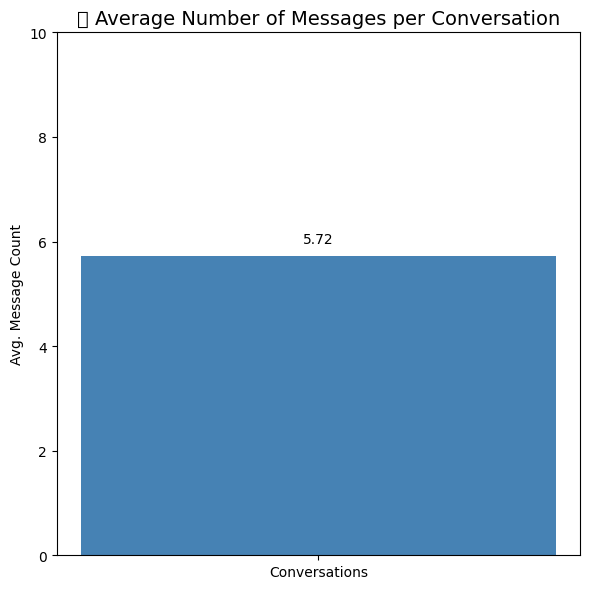

In [2]:
import json
import matplotlib.pyplot as plt

with open("gulf_chats_merged_all.json", "r", encoding="utf-8") as f:
    data = json.load(f)

num_conversations = len(data)
total_messages = sum(len(chat["messages"]) for chat in data)
avg_messages = total_messages / num_conversations

plt.figure(figsize=(6, 6))
bars = plt.bar(["Conversations"], [avg_messages], color='steelblue')
plt.title("📊 Average Number of Messages per Conversation", fontsize=14)
plt.ylabel("Avg. Message Count")
plt.ylim(0, max(10, avg_messages + 2))  

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


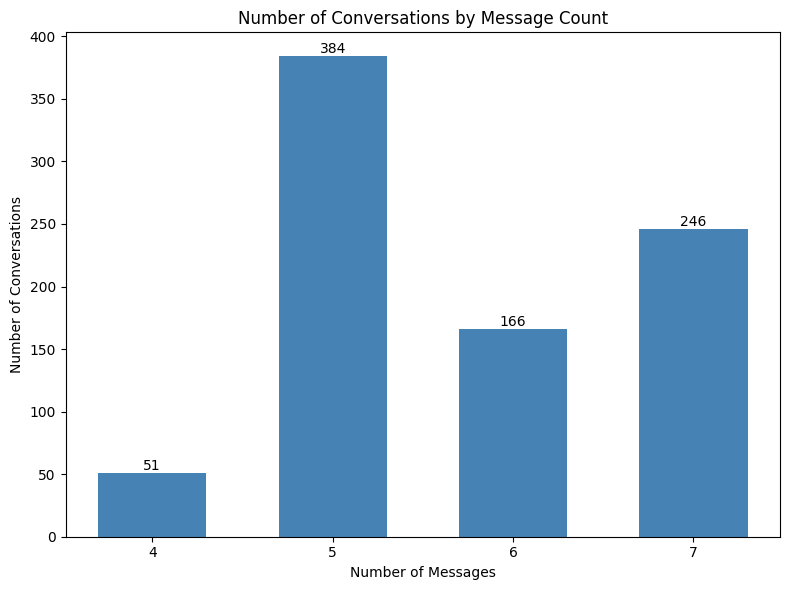

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("gulf_chats_merged_all.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

df['message_count'] = df['messages'].apply(len)

message_dist = df['message_count'].value_counts().sort_index()

filtered_dist = message_dist[(message_dist.index >= 4) & (message_dist.index <= 7)]

plt.figure(figsize=(8, 6))
bars = plt.bar(filtered_dist.index.astype(str), filtered_dist.values, color='steelblue', width=0.6)
plt.title("Number of Conversations by Message Count", fontsize=12)
plt.xlabel("Number of Messages")
plt.ylabel("Number of Conversations")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()